In [8]:
import scipy.io
import numpy as np

# Load the .mat file
data = scipy.io.loadmat("C:/Users/hrush/OneDrive/Documents/P300 Work Praveen Shukala Sir/BCI_Comp_III_Wads_2004/Subject_A_Train.mat")

# Check keys to see available data
print(data.keys())


dict_keys(['__header__', '__version__', '__globals__', 'Signal', 'TargetChar', 'Flashing', 'StimulusCode', 'StimulusType'])


In [11]:
signals = data['Signal']  # Shape might be (trials, channels, time)
print(f"EEG Signal Shape: {signals.shape}")  # Example: (85, 64, 240)
target_chars = data['TargetChar'].flatten()  # Target letter per trial
flashing = data['Flashing']  # When each row/column flashed
stimulus_code = data['StimulusCode']  # Flash sequence
stimulus_type = data['StimulusType']  # 1 = P300, 0 = Non-P300

print(f"TargetChar Shape: {target_chars.shape}")
print(f"Flashing Shape: {flashing.shape}")
print(f"StimulusCode Shape: {stimulus_code.shape}")
print(f"StimulusType Shape: {stimulus_type.shape}")



EEG Signal Shape: (85, 7794, 64)
TargetChar Shape: (1,)
Flashing Shape: (85, 7794)
StimulusCode Shape: (85, 7794)
StimulusType Shape: (85, 7794)


Creating RawArray with float64 data, n_channels=7794, n_times=64
    Range : 0 ... 63 =      0.000 ...     0.263 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 793 samples (3.304 s)



C:\Users\hrush\AppData\Local\Temp\ipykernel_8968\80634131.py:18: RuntimeWarning: filter_length (793) is longer than the signal (64), distortion is likely. Reduce filter length or filter a longer signal.
  raw.filter(1, 30, fir_design='firwin')
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 647 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 881 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 1151 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 1457 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 2177 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 2591 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)

Using matplotlib as 2D backend.


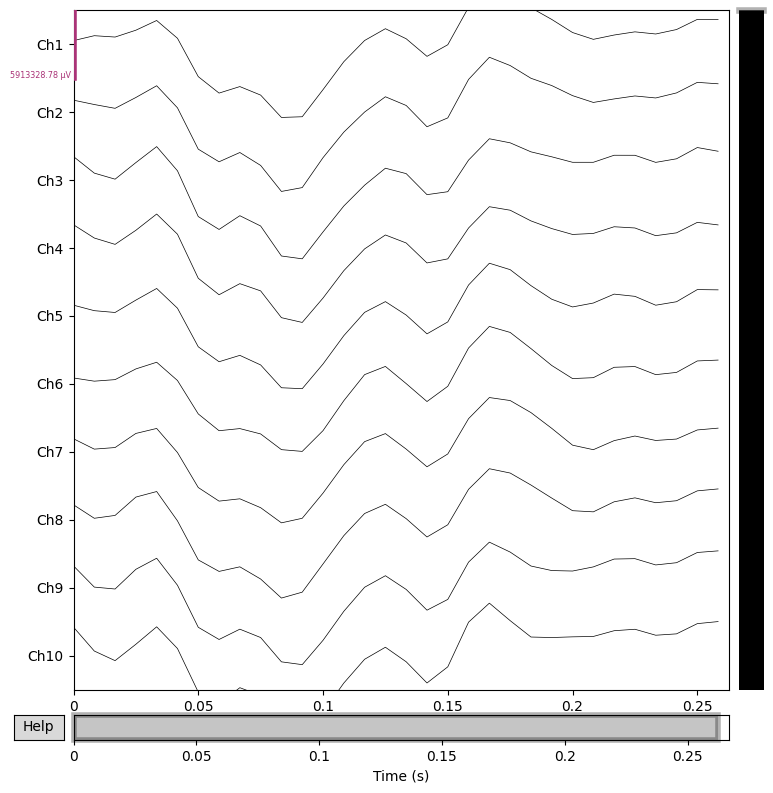

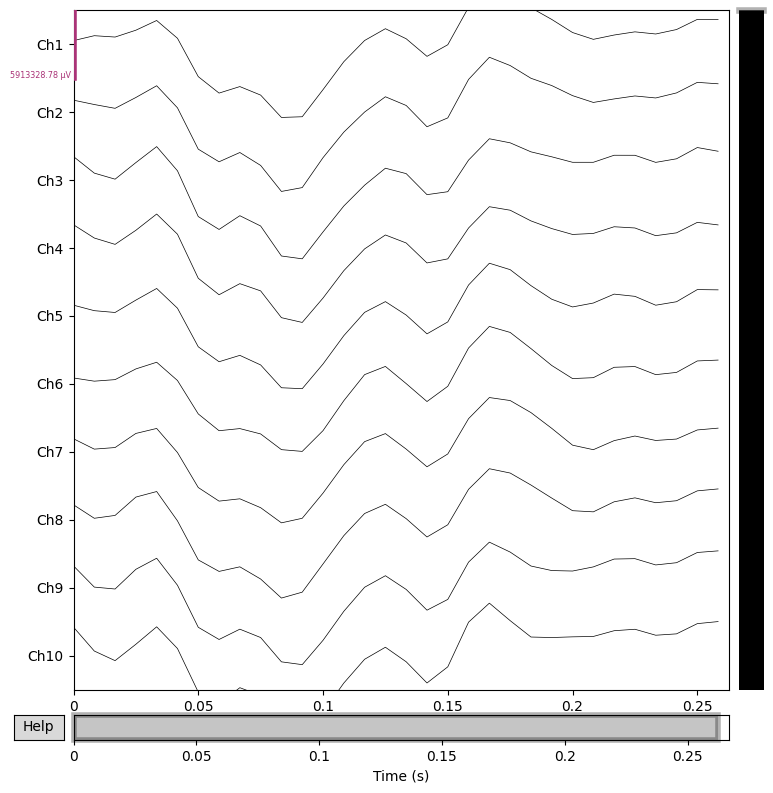

In [12]:
import mne

# Define sampling frequency
sfreq = 240  # Adjust based on dataset documentation
n_channels = signals.shape[1]

# Create channel names
ch_names = [f"Ch{i+1}" for i in range(n_channels)]

# Create MNE Info object
info = mne.create_info(ch_names, sfreq, ch_types='eeg')

# Convert EEG data to MNE format (averaging across trials)
raw_data = np.mean(signals, axis=0)  # Averaging across trials for simplicity
raw = mne.io.RawArray(raw_data, info)

# Apply bandpass filter (1-30 Hz for P300 detection)
raw.filter(1, 30, fir_design='firwin')

# Plot EEG data
raw.plot(n_channels=10, scalings='auto', title="Filtered EEG")


In [18]:
from sklearn.model_selection import train_test_split
    # Define MNE Info object
sfreq = 240  # Sampling frequency (check dataset info)
n_channels = signals.shape[1]
ch_names = [f"Ch{i+1}" for i in range(n_channels)]
info = mne.create_info(ch_names, sfreq, ch_types='eeg')

# Normalize EEG signals
signals = (signals - np.mean(signals)) / np.std(signals)

# Reshape for deep learning (trials, channels, time, 1) for CNN input
signals = signals[..., np.newaxis]  # Add channel dimension
print(f"Reshaped EEG: {signals.shape}")  # (trials, channels, time, 1)




Reshaped EEG: (85, 7794, 64, 1, 1, 1, 1)


In [40]:
# Extract EEG signals and stimulus labels
signals = data['Signal']  # EEG data (trials, channels, time)
labels = data['StimulusType']  # P300 labels (1 = P300, 0 = non-P300)

print(f"Signals Shape: {signals.shape}")  # (trials, channels, time)
print(f"Labels Shape: {labels.shape}")  # (trials,)

# Check if labels match signals
assert signals.shape[0] == labels.shape[0], "Mismatch between signals and labels!"


Signals Shape: (85, 7794, 64)
Labels Shape: (85, 7794)


In [39]:
X_train, X_test, y_train, y_test = train_test_split(signals, labels, test_size=0.2, random_state=42)

print(f"Training data shape: {X_train.shape}")
print(f"Test data shape: {X_test.shape}")


Training data shape: (68, 7794, 64, 1)
Test data shape: (17, 7794, 64, 1)


In [29]:
from tensorflow.keras import layers, models
import tensorflow.keras.backend as K

# Capsule layer function
def squash(vectors, axis=-1):
    s_squared_norm = K.sum(K.square(vectors), axis, keepdims=True)
    scale = s_squared_norm / (1 + s_squared_norm) / K.sqrt(s_squared_norm + K.epsilon())
    return scale * vectors

# Capsule Network Model
def build_capsnet(input_shape, n_classes=2):
    inputs = layers.Input(shape=input_shape)

    # Conv Layer
    x = layers.Conv2D(32, (3, 3), strides=1, padding="same", activation="relu")(inputs)
    x = layers.MaxPooling2D((2, 2), strides=2)(x)

    # Primary Capsules
    x = layers.Conv2D(64, (3, 3), strides=1, padding="same", activation="relu")(x)
    x = layers.Reshape((x.shape[1] * x.shape[2], x.shape[3]))(x)
    x = layers.Lambda(squash)(x)

    # Digit Capsules
    x = layers.Dense(32, activation="relu")(x)
    x = layers.Reshape((-1, 16))(x)  # 16D capsule representation
    x = layers.Lambda(squash)(x)

    # Output Layer
    x = layers.Flatten()(x)
    outputs = layers.Dense(n_classes, activation="softmax")(x)

    model = models.Model(inputs, outputs, name="ERP_CapsNet")
    return model

# Define input shape
input_shape = (X_train.shape[1], X_train.shape[2], 1)

# Build model
capsnet = build_capsnet(input_shape)

# Compile the model
capsnet.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

capsnet.summary()


Model: "ERP_CapsNet"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 7794, 64, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 7794, 64, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 3897, 32, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 3897, 32, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 124704, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda (Lambda)                 │ (None, 124704, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 124704, 32)     │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 249408, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_1 (Lambda)               │ (None, 249408, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3990528)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │     7,981,058 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,001,954 (30.53 MB)

 Trainable params: 8,001,954 (30.53 MB)

 Non-trainable params: 0 (0.00 B)

In [41]:
y_train = np.argmax(y_train, axis=1)  # Convert one-hot to class indices
y_test = np.argmax(y_test, axis=1)

print(f"Fixed Labels Shape: {y_train.shape}, {y_test.shape}")  # Should be (samples,)


Fixed Labels Shape: (68,), (17,)


In [37]:
history = capsnet.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/30


AttributeError: 'NoneType' object has no attribute 'items'

In [35]:
from sklearn.model_selection import train_test_split
    # Define MNE Info object
sfreq = 240  # Sampling frequency (check dataset info)
n_channels = signals.shape[1]
ch_names = [f"Ch{i+1}" for i in range(n_channels)]
info = mne.create_info(ch_names, sfreq, ch_types='eeg')

# Normalize EEG signals
signals = (signals - np.mean(signals)) / np.std(signals)

# Reshape for deep learning (trials, channels, time, 1) for CNN input
signals = signals[..., np.newaxis]  # Add channel dimension
print(f"Reshaped EEG: {signals.shape}")  # (trials, channels, time, 1)




Reshaped EEG: (85, 7794, 64, 1)


In [49]:
import tensorflow as tf
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
print(np.any(np.isnan(X_train)))
print(np.any(np.isinf(X_train)))
print(np.any(np.isnan(y_train)))
print(np.any(np.isinf(y_train)))
capsnet.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
capsnet.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
y_train = tf.keras.utils.to_categorical(y_train, num_classes=2)  # Adjust num_classes if needed
y_test = tf.keras.utils.to_categorical(y_test, num_classes=2)  # Adjust num_classes if needed
print("Unique labels in y_train:", np.unique(y_train))
print("Unique labels in y_test:", np.unique(y_test))






(68, 7794, 64, 1) (68,)
(17, 7794, 64, 1) (17,)
False
False
False
False


IndexError: index 378 is out of bounds for axis 1 with size 2

In [46]:
# Example of a basic model for testing
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten

simple_model = Sequential([
    Flatten(input_shape=(X_train.shape[1], X_train.shape[2], X_train.shape[3])),
    Dense(128, activation='relu'),
    Dense(2, activation='softmax')  # Adjust for binary or multi-class classification
])

simple_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = simple_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))


c:\Users\hrush\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10


ValueError: Arguments `target` and `output` must have the same rank (ndim). Received: target.shape=(None,), output.shape=(None, 2)